In [1]:
%config InlineBackend.figure_format = "svg"

from __future__ import annotations
from typing import Type, Union
import networkx as nx
import pandas as pd
import numpy as np

### Defining types

In [2]:
Id = (str, int)
Edge = (Id, Id)
Node = Union["StateNode", "EvidenceNode", "ActionNode", "UtilityNode"]

### Node classes

In [3]:
class StateNode:
    def __init__(self, name: str, time: int):
        self.name: str = name
        self.time: int = time
        
    def get_id(self) -> Id:
        return (self.name, self.time)
            
    def get_name(self):
        return self.name
            
    def get_time(self):
        return self.time

    def add_pt(self, pt: dict[Union[Id, str], list[int]]):
        self.pt = pd.DataFrame(pt)
        
    def get_sample(self, sample: dict[Id, int]) -> pd.DataFrame:
        # Get the row relative to the current sample where current node is false
        sample = {k: v for k, v in sample.items() if (k in self.pt) and (k != self.get_id())}
        df = self.pt
        for node_id in sample:
            df = df.loc[df[node_id] == sample[node_id]]
        df = df.loc[df[self.get_id()] == 0]
        
        # Generate random number
        number = np.random.uniform()
        r = int(np.random.uniform() > df["Prob"])
        
        return r
        
    
class EvidenceNode(StateNode):
    pass


class ActionNode(StateNode):
    def __init__(self, name: str, time: int, actions: list[int]):
        super().__init__(name, time)
        self.actions = actions
        
    def get_actions(self) -> list[int]:
        return self.actions
        
    def add_value(self, value: int):
        self.pt = pd.DataFrame({self.get_id(): [value, 1-value], "Prob": [1, 0]})


class UtilityNode(StateNode):
    pass

## Dynamic Decision Network Class

In [4]:
class DynamicDecisionNetwork:
    def __init__(self):
        self.node_map: dict[Id, Node] = {}
        self.graph: dict[Id, [Id]] = {}
        self.knowns: list[Id, int] = {}
        self.time: int = 0
        
    def add_nodes(self, nodes: list[Node]):
        for node in nodes:
            if node.get_id() not in self.node_map:
                self.node_map[node.get_id()] = node
                self.graph[node.get_id()] = []
        
    def add_edges(self, edges: list[Edge]):
        for edge in edges:
            s, d = edge
            if s not in self.graph:
                self.graph[s] = []
            self.graph[s].append(d)
            
    def draw(self):
        # Create nx graph
        G = nx.DiGraph(directed=True)
        G.add_edges_from(self.get_edges())
        pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
        
        # Draw state nodes
        state_nodes = self.get_nodes_by_type(StateNode)
        nx.draw_networkx_nodes(G, pos, nodelist=state_nodes, node_color="gray", node_size=3000, node_shape="o")
        
        # Draw state nodes
        evidence_nodes = self.get_nodes_by_type(EvidenceNode)
        nx.draw_networkx_nodes(G, pos, nodelist=evidence_nodes, node_color="orange", node_size=3000, node_shape="o")
        
        # Draw action nodes
        action_nodes = self.get_nodes_by_type(ActionNode)
        nx.draw_networkx_nodes(G, pos, nodelist=action_nodes, node_color="tab:blue", node_size=3000, node_shape="s")
        
        # Draw action nodes
        utility_nodes = self.get_nodes_by_type(UtilityNode)
        nx.draw_networkx_nodes(G, pos, nodelist=utility_nodes, node_color="green", node_size=3000, node_shape="d")
        
        # Draw network edges
        nx.draw_networkx_edges(G, pos)
        
        # Draw node labels
        labels = {n: n for n in self.node_map}
        nx.draw_networkx_labels(G, pos, labels)
            
    def is_leaf(self, node_id: Id) -> bool:
        # For a node to be leaf it cant have children
        return len(self.graph[node_id]) == 0
    
    def is_root(self, node_id: Id) -> bool:
        # For a node to be root it cant have parents
        parents = []
        for key in self.graph:
            if node_id in self.graph[key]:
                parents.append(key)
        return len(parents) == 0
        
    def get_edges(self) -> list[(Id, Id)]:
        edges = []
        for s in self.graph:
            for d in self.graph[s]:
                edges.append((s, d))
        return edges
        
    def add_pt(self, node_id: Id, pt: dict[Union[Id, str], int]):
        self.node_map[node_id].add_pt(pt)
        
    def get_nodes_by_type(self, node_type: Type(Node)) -> list[Id]:
        return [k for k, v in self.node_map.items() if type(v) is node_type]
    
    def get_nodes_by_type_and_time(self, node_type: Type(Node), time: int) -> list[Id]:
        return [node for node in self.get_nodes_by_type(node_type) if self.node_map[node].get_time() == time]
    
    def query(self, query: list[Id], evidence: dict[Id, int] = {}, n_samples: int = 1000) -> pd.DataFrame:
        
        # Add value of actions to the nodes
        action_nodes = [k for k in evidence if type(self.node_map[k]) is ActionNode]
        for node in action_nodes:
            self.node_map[node].add_value(evidence[node])
        
        # Create empty sampling dictionary
        sample_dict = {node_id: [] for node_id in self.node_map}
        
        # Create multiple samples
        cur_samples = 0
        while (cur_samples < n_samples):
            
            # Create empty sample
            sample = {}
            queue = [k for k in self.node_map if self.is_root(k)]
            
            # Sample a result from each root node
            while len(queue) != 0:
                
                # Sample from head of queue
                sample[queue[0]] = self.node_map[queue[0]].get_sample(sample)
                
                # Add head's children to queue
                queue += self.graph[queue[0]]
                
                # Remove head from queue
                queue.pop(0)
            
            # Pass sample results to sample_dict if it matches with evidence
            matches = [sample[node_id] == evidence[node_id] for node_id in evidence]
            if all(matches):
                for node_id in sample_dict:
                    sample_dict[node_id].append(sample[node_id])
                cur_samples += 1
                
        # Turn result into probability table
        df = pd.DataFrame(sample_dict)
        df = df.value_counts(normalize=True).to_frame("Prob")
        
        # Group over query variables and sum over all other variables
        df = df.groupby(query).sum().reset_index()
        
        return df
    
    def increase_time_step(self):
        # Increase every node time step
        order_key = lambda nid: -nid[1] # Order them in decreasing time order
        node_ids = sorted([nid for nid in self.node_map], key=order_key)
        for (name, t) in node_ids:
            self.node_map[(name, t)].time += 1
            self.node_map[(name, t+1)] = self.node_map.pop((name, t))
            
        # Increase every edge time step
        for (n1, t1) in node_ids:
            for i, (n2, t2) in enumerate(self.graph[(n1, t1)]):
                self.graph[(n1, t1)][i] = (n2, t2+1)
            self.graph[(n1, t1+1)] = self.graph.pop((n1, t1))
            
        # Increase own time clock
        self.time += 1
    
    def initialize(self):
        # Get all evidence and reward nodes ids
        init_nodes = self.get_nodes_by_type(EvidenceNode) + self.get_nodes_by_type(UtilityNode)
        
        # Get a single sample from the initial network
        self.node_map[("Action", 0)].add_value(1) # FIX THIS
        sample = self.query(query=init_nodes, n_samples=1)
        sample = {col: int(sample[col]) for col in sample if col != "Prob"}
        self.knowns = sample
        
        # Increase the time for every node and edge
        self.increase_time_step()
        
        # Add A0 Nodes as copy of A1 Nodes
        A1Nodes = self.get_nodes_by_type(ActionNode)
        A0Nodes = []
        for node_id in A1Nodes:
            node = self.node_map[node_id]
            A0Nodes.append(ActionNode(node.get_name(), node.get_time()-1, node.get_actions()))
        self.add_nodes(A0Nodes)
        
        # Add E1 Nodes as copy of E2 Nodes
        E2Nodes = self.get_nodes_by_type(EvidenceNode)
        E1Nodes = []
        for node_id in E2Nodes:
            node = self.node_map[node_id]
            E1Nodes.append(EvidenceNode(node.get_name(), node.get_time()-1))
        self.add_nodes(E1Nodes)
        
        # Add R1 Nodes as copy of R2 Nodes
        R2Nodes = self.get_nodes_by_type(UtilityNode)
        R1Nodes = []
        for node_id in R2Nodes:
            node = self.node_map[node_id]
            R1Nodes.append(UtilityNode(node.get_name(), node.get_time()-1))
        self.add_nodes(R1Nodes)
        
        # Get X1 and X2 nodes
        X1Nodes = self.get_nodes_by_type_and_time(StateNode, self.time)
        X2Nodes = self.get_nodes_by_type_and_time(StateNode, self.time+1)
        
        # Add every edge that's missing
        for (n1, t1) in self.graph:
            # Add Edges (A0, X1) as copy of (A1, X2)
            if (n1, t1) in A1Nodes:
                for (n2, t2) in self.graph[(n1, t1)]:
                    if (n2, t2) in X2Nodes:
                        self.graph[(n1, t1-1)].append((n2, t2-1))
        
            elif (n1, t1) in X2Nodes:
                for (n2, t2) in self.graph[(n1, t1)]:
                    # Add Edges (X1, E1) as copy of (X2, E2)
                    if (n2, t2) in E2Nodes:
                        self.graph[(n1, t1-1)].append((n2, t2-1))
        
                    # Add Edges (X1, R1) as copy of (X2, R2)
                    elif (n2, t2) in R2Nodes:
                        self.graph[(n1, t1-1)].append((n2, t2-1))
        
        # Change X1 cpt to X2 cpt
        for (n, t) in X2Nodes:
            self.node_map[(n, t-1)].pt = self.node_map[(n, t)].pt
        

## Defining the DNN initial structure

In [5]:
# Create nodes
state_node0 = StateNode("State", 0)
state_node1 = StateNode("State", 1)
ev_node = EvidenceNode("Evidence", 1)
util_node = UtilityNode("Reward", 1)
action_node = ActionNode("Action", 0, [0, 1])

# Create the initial DDN structure
bn = DynamicDecisionNetwork()
bn.add_nodes([state_node0, state_node1, ev_node, util_node, action_node])
bn.add_edges([
    (("State", 0), ("State", 1)), 
    (("Action", 0), ("State", 1)), 
    (("State", 1), ("Evidence", 1)), 
    (("State", 1), ("Reward", 1))
])

## Giving the DNN its probability tables

In [6]:
# Add data for node State 0
data = {("State", 0): [0,1], "Prob": [1,0]}
bn.add_pt(("State", 0), data)

# Add data for node State 1
data = {
    ("State", 0): [0,0,0,0,1,1,1,1], ("Action", 0): [0,0,1,1,0,0,1,1], ("State", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [0.5,0.5,0.9,0.1,0.7,0.3,0.4,0.6]
}
bn.add_pt(("State", 1), data)

# Add data for node Evidence
data = {("State", 1): [0,0,1,1], ("Evidence", 1): [0,1,0,1], "Prob": [0.8,0.2,0.2,0.8]}
bn.add_pt(("Evidence", 1), data)

# Add data for node Utility
data = {("State", 1): [0,0,1,1], ("Reward", 1): [0,1,0,1], "Prob": [1,0,0.1,0.9]}
bn.add_pt(("Reward", 1), data)

## Drawing the initial Decision Network

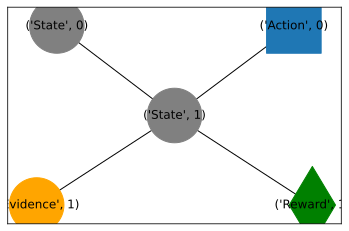

In [7]:
bn.draw()

## Initializing the network for the next time-step

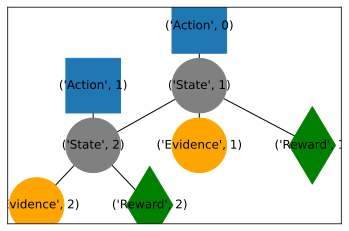

In [8]:
bn.initialize()
bn.draw()